In [1]:
from siphon.catalog import TDSCatalog
from json import dumps
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from datetime import timedelta, datetime

In [236]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
cat = TDSCatalog('https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_mr/catalog.xml')

In [3]:
years_of_interest = ['2018', '2019']

In [4]:
for year_ref in sorted(cat.catalog_refs):
    if year_ref in years_of_interest:
        year_cat = TDSCatalog(cat.catalog_url.rstrip('catalog.xml') + year_ref + '/catalog.xml')
        for month_ref in sorted(year_cat.catalog_refs):
            month_cat = TDSCatalog(year_cat.catalog_url.rstrip('catalog.xml') + month_ref + '/catalog.xml')
            print(f'OSISAF MR Catalog: {month_cat.catalog_url}\tn_datasets: {len(month_cat.datasets)}')

OSISAF MR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_mr/2018/01/catalog.xml	n_datasets: 60
OSISAF MR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_mr/2018/02/catalog.xml	n_datasets: 55
OSISAF MR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_mr/2018/03/catalog.xml	n_datasets: 61
OSISAF MR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_mr/2018/04/catalog.xml	n_datasets: 59
OSISAF MR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_mr/2018/05/catalog.xml	n_datasets: 61
OSISAF MR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_mr/2018/06/catalog.xml	n_datasets: 57
OSISAF MR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_mr/2018/07/catalog.xml	n_datasets: 62
OSISAF MR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_mr/2018/08/catalog.xml	n_datasets: 62
OSISAF MR Catalog: https://thredds.met.n

In [11]:
weeks = pd.date_range('2019-12-01','2019-12-31', freq='W')

In [12]:
weeks

DatetimeIndex(['2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22',
               '2019-12-29'],
              dtype='datetime64[ns]', freq='W-SUN')

In [184]:
groupings = {
    w.strftime('%Y-%m-%d'): [
        x for x in month_cat.datasets if (
            (datetime.strptime(x.split('_')[-2], '%Y%m%d%H%M%S') >= w.to_pydatetime()) & 
            (datetime.strptime(x.split('_')[-2], '%Y%m%d%H%M%S') <= w.to_pydatetime() + timedelta(days=6, hours=23, minutes=59, seconds=59))
        )
    ]
    for w in weeks
}

In [188]:
print('Binning the "daily" datasets into weeks:\n', dumps({k:len(v) for k,v in groupings.items()}, indent=2))

Binning the "daily" datasets into weeks:
 {
  "2019-12-01": 29,
  "2019-12-08": 27,
  "2019-12-15": 29,
  "2019-12-22": 28,
  "2019-12-29": 8
}


In [243]:
first_week = groupings['2019-12-01']

In [244]:
arrs = {}
for data in first_week:
    with xr.open_dataset(month_cat.datasets[data].access_urls['OPENDAP']) as ds:
        arrs[data] = ds[['dX', 'dY']].where(ds['data_status'] == 0)

In [245]:
coords = arrs[data]['dX'].coords
dims = arrs[data]['dX'].dims

Max number of "valid" daily values: 17
Min number of "valid" daily values (ignoring 0): 1


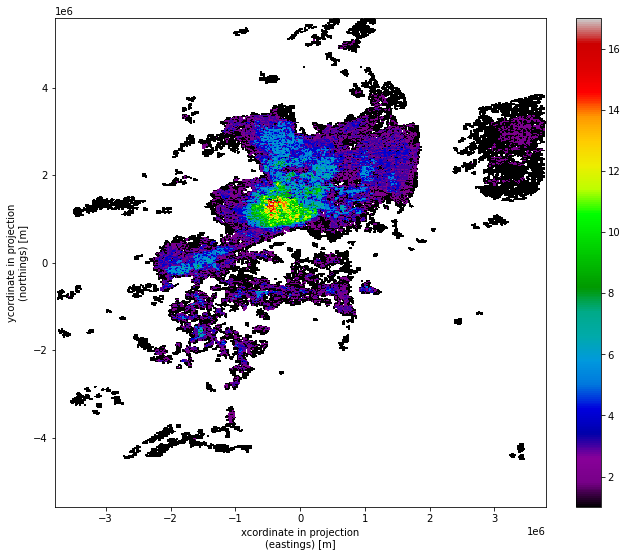

In [246]:
# To see how the first week's datasets compare, we can see where they have overlapping "valid" pixels:
big = np.zeros(arrs[data]['dX'].shape)
_ = [np.add(big, ~np.isnan(arrs[k]['dX']) * 1, out=big) for k in arrs]
big = xr.DataArray(np.ma.masked_where(big == 0, big), coords=coords, dims=dims)
fig, ax = plt.subplots(figsize=(11,9))
im = xr.plot.pcolormesh(big, cmap='nipy_spectral', ax=ax)
print('Max number of "valid" daily values: %d' % np.nanmax(big))
print('Min number of "valid" daily values (ignoring 0): %d' % np.nanmin(big))

In [247]:
dx_arr = np.stack([arrs[k]['dX'] for k in arrs])
dx_mean = xr.DataArray(np.nanmean(dx_arr, axis=0), coords=coords, dims=dims)
dx_median = xr.DataArray(np.nanmedian(dx_arr, axis=0), coords=coords, dims=dims)
dy_mean = xr.DataArray(np.nanmean(np.stack([arrs[k]['dY'] for k in arrs]), axis=0), coords=coords, dims=dims)

dX stats:
Mean stats: min: -23.000 max: 24.000 mean: 1.445 std: 4.111
Median stats: min: -23.000 max: 24.000 mean: 1.485 std: 4.191




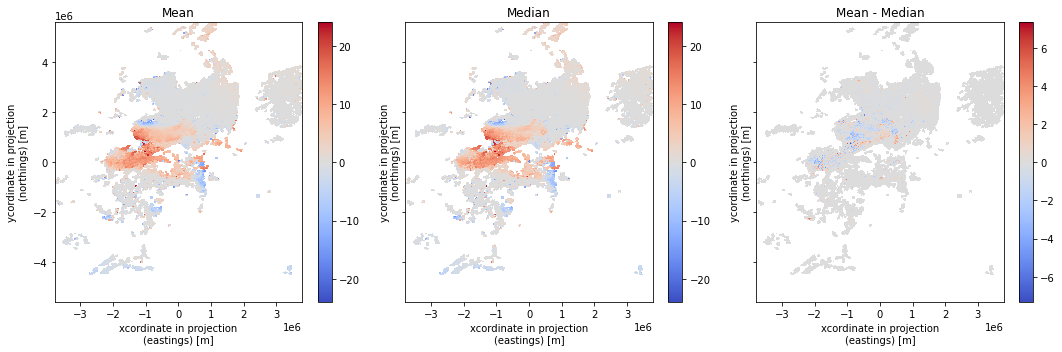

In [248]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,5), ncols=3, sharey=True)
xr.plot.pcolormesh(dx_mean, cmap='coolwarm', ax=ax1)
ax1.set_title('Mean')
xr.plot.pcolormesh(dx_median, cmap='coolwarm', ax=ax2)
ax2.set_title('Median')
xr.plot.pcolormesh(dx_mean - dx_median, cmap='coolwarm', ax=ax3)
ax3.set_title('Mean - Median')
plt.tight_layout()
print('dX stats:\nMean stats: min: %.3f max: %.3f mean: %.3f std: %.3f' % (np.nanmin(mean), np.nanmax(mean), np.nanmean(mean), np.nanstd(mean)))
print('Median stats: min: %.3f max: %.3f mean: %.3f std: %.3f\n\n' % (np.nanmin(median), np.nanmax(median), np.nanmean(median), np.nanstd(median)))

In [249]:
mean_ds = xr.Dataset({'dX':dx_da, 'dY':dy_da})

In [250]:
crs = ccrs.Stereographic(
    central_latitude=90, 
    central_longitude=-45, 
    true_scale_latitude=70, 
    globe=ccrs.Globe(
        ellipse=None,
        semimajor_axis=6378273, 
        semiminor_axis=6356889.44891)
)

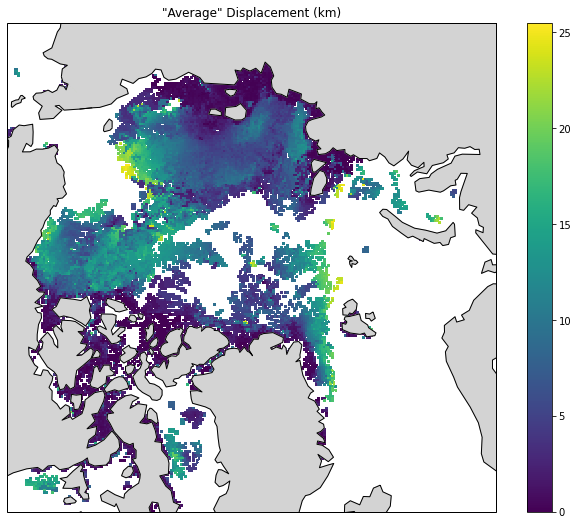

In [251]:
fig, ax = plt.subplots(figsize=(11,9), subplot_kw={'projection': crs})
ax.set_extent([-2.5e6, 2.5e6, -2.5e6, 2.5e6], crs=crs)
ax.coastlines(zorder=3)
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey', zorder=2)
xr.plot.pcolormesh((mean_ds['dY']**2 + mean_ds['dX']**2)**0.5, ax=ax)
ax.set_title('"Average" Displacement (km)');

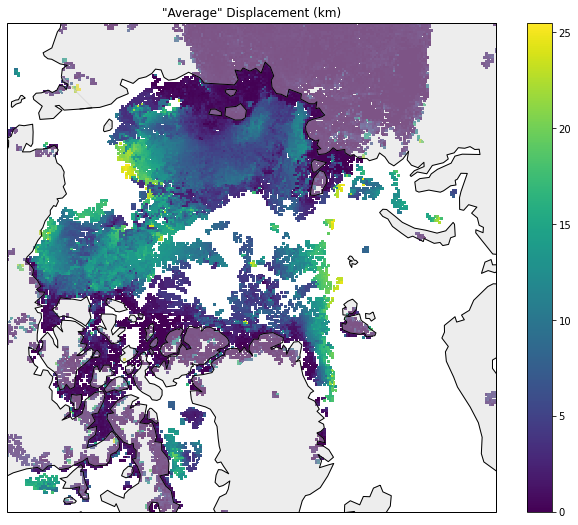

In [252]:
fig, ax = plt.subplots(figsize=(11,9), subplot_kw={'projection': crs})
ax.set_extent([-2.5e6, 2.5e6, -2.5e6, 2.5e6], crs=crs)
ax.coastlines(zorder=3)
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey', alpha=0.4, zorder=2)
xr.plot.pcolormesh((mean_ds['dY']**2 + mean_ds['dX']**2)**0.5, ax=ax)
ax.set_title('"Average" Displacement (km)');